# Mine 5on5 Shift Data
We begin by mining all shift data from the NHL public API. Then we will filter shifts by 5on5.

In [1]:
import json
import requests
import pprint
import pandas as pd
import numpy as np
import math

### Demo for a Single Game
Demonstrate the process of mining/feature engineering on the 07Dec2021 Hurricanes vs Jets game.

##### Retrieve Data
We begin with pulling shift data from the [NHL API](https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId=2021020395). Using the start and end time of each shift, we will create a record that says that player was on the ice at that time.

In [2]:
def calc_gametime_second(period, time):
    time_in_seconds = int(time[:2]) * 60 + int(time[3:])
    return (period - 1) * 1200 + time_in_seconds

def get_all_shifts(d):
    # add resolution to shift observations, track each second each shift lasted for
    shift_data = []
    for shift in d['data']:
        start = calc_gametime_second(shift['period'], shift['startTime']) # calculate startTime of shift
        end = calc_gametime_second(shift['period'], shift['endTime'])     # calculate endTime of shift
        seconds_on_ice = [{
            'gameId': shift['gameId'],
            'teamId': shift['teamId'],
            'playerId': shift['playerId'],
            'time': t,
            'onIce': True,
        } for t in range(start, end)] # for each second this player is on the ice, create a row
        shift_data.extend(seconds_on_ice)
        
    return shift_data

In [3]:
# get data
game_id = '2021020395'
r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={game_id}')
d = r.json()

shift_data = get_all_shifts(d)
    
pd.DataFrame(shift_data).head()

,gameId,teamId,playerId,time,onIce
0,2021020395,52,8471218,30,True
1,2021020395,52,8471218,31,True
2,2021020395,52,8471218,32,True
3,2021020395,52,8471218,33,True
4,2021020395,52,8471218,34,True


Above is a sample of the DataFrame created from the modified shift data. The first record states that player 8471218, who plays for team 52, was on the ice at time=30 of game 2021020395. We'll see later that this player is Blake Wheeler of the Winnipeg Jets.

##### Filter by 5on5 Shifts

Next, we'll use groupby's to determine how many player are on the ice for each team. We only want to include scenarios where teams have 5 skaters each, so we'll find those timeframes here. Also note, there is some data cleaning in this section as some shift data is recorded incorrectly and teams appear to have 7 skaters on the ice.

In [4]:
def get_5on5_shifts(shift_data):
    # create dataframe object to store time on ice data
    df = pd.DataFrame(shift_data)

    # variable to help with counting the number of players on the ice
    df['numPlayers'] = 1

    # group players together by the time of game, sum the number of players on the ice for this second
    df_strength = df[['teamId', 'time', 'numPlayers']].groupby(['time', 'teamId'], as_index=False).sum()
    
    # for some games, data entry is messed up, recording 7 players on the ice for a team
    df_strength['numPlayers'] = np.where(df_strength['numPlayers']>=7, 6, df_strength['numPlayers'])

    # convert dataframe from long to wide
    df_strength = df_strength.pivot(index='time', columns='teamId', values='numPlayers')

    # calculate player differential of two teams
    df_strength['is_5on5'] = (df_strength[df_strength.columns[0]]==6) & (df_strength[df_strength.columns[1]]==6)
    
    # merge with original df
    df = df.merge(df_strength[['is_5on5']], on='time')

    return df[df['is_5on5']]

In [5]:
# return 5on5 icetime
df = get_5on5_shifts(shift_data)

df.head()

,gameId,teamId,playerId,time,onIce,numPlayers,is_5on5
0,2021020395,52,8471218,30,True,1,True
1,2021020395,12,8475799,30,True,1,True
2,2021020395,12,8475883,30,True,1,True
3,2021020395,52,8476460,30,True,1,True
4,2021020395,12,8476869,30,True,1,True


The DataFrame now contains only shifts of 5on5 play.

##### Filter by Position (we only care about forwards)
Now that we have 5on5 timeframes, we can drop defensemen and goalies from our dataset. This will allow us to focus on forward line combinations only.

This section requires us to retrieve additional roster data from the [NHL API](https://statsapi.web.nhl.com/api/v1/game/2021020395/boxscore) to identify player positions.

In [6]:
def get_forward_shifts(df, game_id):
    # retrieve roster for this game
    r = requests.get(url=f'https://statsapi.web.nhl.com/api/v1/game/{game_id}/boxscore')
    d = r.json()
    
    # get list of away players
    players = [{
        'playerId': val['person']['id'],
        'fullName': val['person']['fullName'],
        'primaryPosition': val['person']['primaryPosition']['code'],
        'primaryPositionType': val['person']['primaryPosition']['type']
        
    } for key, val in d['teams']['away']['players'].items()]
    
    # get list of home players, add it to list of away players
    players.extend([{
        'playerId': val['person']['id'],
        'fullName': val['person']['fullName'],
        'primaryPosition': val['person']['primaryPosition']['code'],
        'primaryPositionType': val['person']['primaryPosition']['type']
        
    } for key, val in d['teams']['home']['players'].items()])
    
    # convert to df
    df_players = pd.DataFrame(players)
    
    # merge with original df
    df = df.merge(df_players, on='playerId')

    # filter by fowards
    df = df[df['primaryPositionType']=='Forward']
    
    df.drop(['numPlayers', 'is_5on5', 'primaryPosition', 'primaryPositionType'], axis=1, inplace=True)
    
    return df

In [7]:
# filter to include forwards only
df = get_forward_shifts(df, game_id)

df.head()

,gameId,teamId,playerId,time,onIce,fullName
0,2021020395,52,8471218,30,True,Blake Wheeler
1,2021020395,52,8471218,31,True,Blake Wheeler
2,2021020395,52,8471218,32,True,Blake Wheeler
3,2021020395,52,8471218,33,True,Blake Wheeler
4,2021020395,52,8471218,34,True,Blake Wheeler


Now, the DataFrame consists exclusively of forwards. We will validate this by plotting the number of forwards that appear on the ice for each team as a time series. We expect to see a constant of 3 forwards throughout the game for each team.

array([<AxesSubplot:xlabel='time'>, <AxesSubplot:xlabel='time'>],
      dtype=object)

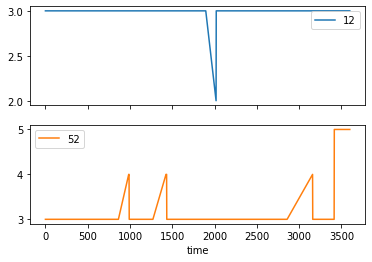

In [8]:
df_tmp = df.copy()
df_tmp['numPlayers'] = 1
df_tmp = df_tmp[['teamId', 'time', 'numPlayers']].groupby(['time', 'teamId'], as_index=False).sum() # count fwds on ice
df_tmp = df_tmp.pivot(index='time', columns='teamId', values='numPlayers') # pivot so that teams are columns
df_tmp.plot.line(subplots=True) # plot

* For teamId 12 (Carolina Hurricanes), there is one instance of having less than 2 forwards on the ice, at t=2017 seconds. This corresponds to a penalty ending in the second period:
    * Penalty taken by Ian Cole at 11:37 of period 2
    * Penalty expires at 13:37, defenseman Ian Cole leaves the leaving the Hurricanes with 2 forwards and 3 defensemen on the ice
    * Stoppage of play at 13:39, allowing the Hurricanes to reset their lines
    
* For teamId 52 (Winnipeg Jets)
    * At t=984 (16:24 of period 1), Hurricanes penalty ends, Jets stuck with 4 forwards until change can be made
    * Happens again right before t=1500 (2 minute minor) and right after t=3000 (5 minute major)
    * At t=3415 (16:54 of period 3), Jets pull their goalie and go with 5 forwards, 1 defensman until end of game
    
##### Group by Lines
Now we can match players up as lines. We will do this using groupby's and sums. The grouping mechanism first groups players together by their teamId, then by time (timeframe they appear on ice), and then an identifier is created. The identifier concatenates the playerId's of the players on the ice for a team. 

For example, if Martin Necas, Seth Jarvis, and Vincent Trocheck appear on the ice together, the identifier will look like 'Martin Necas_Seth Jarvis_Vincent Trocheck'. The total number of seconds will appear next to the identifier.

In [9]:
def get_groups_shifts_playerIds(df):
    df_tmp = df[['gameId', 'teamId', 'time', 'playerId']].copy() # create copy
    df_tmp = df_tmp.sort_values(['teamId', 'time', 'playerId']) # sort by playerId (so that identifier created is consistent)
    df_tmp['playerId'] = df_tmp['playerId'].astype(str)         # convert playerId to string
    df_tmp = df_tmp.groupby(['gameId','teamId','time'])['playerId'].apply(lambda x: '_'.join(x)).reset_index() # create identifier
    
    # calculate total time on ice for this line combination
    df_tmp['time'] = 1
    df_tmp = df_tmp.groupby(['gameId', 'teamId', 'playerId']).sum().reset_index()
    
    # calculate num forwards on this line
    df_tmp['numFwds'] = df_tmp['playerId'].str.count('_') + 1
    
    # rename cols
    df_tmp.rename({'playerId': 'lineId', 'time': 'seconds'}, axis=1, inplace=True)
    
    return df_tmp.sort_values('seconds', ascending=False)

def get_groups_shifts_fullNames(df):
    '''Same as above def, just creates identifier with fullNames instead'''
    # create line identifier
    df_tmp = df[['gameId', 'teamId', 'time', 'fullName']].copy()
    df_tmp = df_tmp.sort_values(['teamId', 'time', 'fullName'])
    df_tmp = df_tmp.groupby(['gameId', 'teamId','time'])['fullName'].apply(lambda x: '_'.join(x)).reset_index()
    
    # calculate toi for line
    df_tmp['time'] = 1
    df_tmp = df_tmp.groupby(['gameId', 'teamId', 'fullName']).sum().reset_index()
    df_tmp.sort_values('time', ascending=False).head(10)
    
    # calculate num forwards on this line
    df_tmp['numFwds'] = df_tmp['fullName'].str.count('_') + 1
    
    # rename cols
    df_tmp.rename({'playerId': 'lineId', 'time': 'seconds'}, axis=1, inplace=True)
    
    return df_tmp.sort_values('seconds', ascending=False)

In [10]:
# group players by shift
df_playerIds = get_groups_shifts_playerIds(df)
df_fullNames = get_groups_shifts_fullNames(df)


display(df_playerIds.head(12))
display(df_fullNames.head(12))

,gameId,teamId,lineId,seconds,numFwds
4,2021020395,12,8473533_8475855_8480830,737,3
63,2021020395,52,8477429_8477940_8479400,619,3
13,2021020395,12,8475799_8476882_8478427,606,3
33,2021020395,52,8471218_8476460_8478398,605,3
24,2021020395,12,8476389_8480039_8482093,475,3
40,2021020395,52,8471669_8476392_8480005,415,3
10,2021020395,12,8474613_8478904_8480829,361,3
61,2021020395,52,8476952_8478424_8478431,325,3
32,2021020395,52,8471218_8476460_8477940_8478398_8479400,116,5
55,2021020395,52,8476460_8478398_8478431,81,3


,gameId,teamId,fullName,seconds,numFwds
2,2021020395,12,Andrei Svechnikov_Jesper Fast_Jordan Staal,737,3
47,2021020395,52,Andrew Copp_Nikolaj Ehlers_Pierre-Luc Dubois,619,3
26,2021020395,12,Nino Niederreiter_Sebastian Aho_Teuvo Teravainen,606,3
49,2021020395,52,Blake Wheeler_Kyle Connor_Mark Scheifele,605,3
22,2021020395,12,Martin Necas_Seth Jarvis_Vincent Trocheck,475,3
38,2021020395,52,Adam Lowry_Kristian Vesalainen_Paul Stastny,415,3
11,2021020395,12,Derek Stepan_Jesperi Kotkaniemi_Steven Lorentz,361,3
53,2021020395,52,Dominic Toninato_Evgeny Svechnikov_Jansen Harkins,325,3
50,2021020395,52,Blake Wheeler_Kyle Connor_Mark Scheifele_Nikol...,116,5
59,2021020395,52,Evgeny Svechnikov_Kyle Connor_Mark Scheifele,81,3


Above we see the grouping of lines for this game. This data can be plotted like so:

<AxesSubplot:xlabel='fullName'>

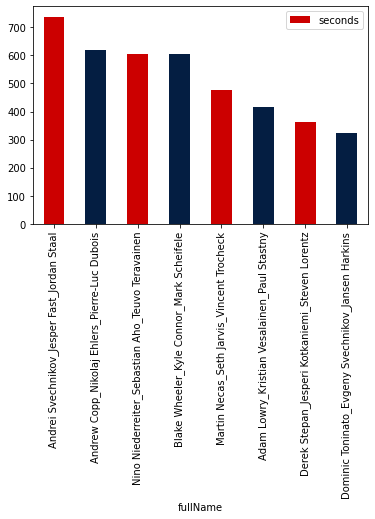

In [11]:
# assign colors
df_fullNames['color'] = np.where(df_fullNames['teamId']==12, '#CC0000', '#041E42')

# plot
df_fullNames.head(8).plot.bar(x='fullName', y='seconds', color=df_fullNames['color'])

##### Save Line Data
Save the file containing playerIds as line identifiers. This dataset is more flexible.

In [12]:
with open('../data/shifts_forwards_5on5.csv', 'w') as f:
    df_playerIds.to_csv(f)

### Automate Data Mining for All Games in 2020-21 and 2021-22

In [13]:
# Set up the API call variables
year = ['2020', '2021']    # 2020-2021 season and 2021-2022
season_type = '02'        # 02 is regular season
max_game_ID = [869, 402]  # max number of games in season (changes depending on season)

In [14]:
# keep track of all games in this list
all_shifts = []

for i in range(0, len(year)):
    for game_num in range(1, max_game_ID[i]):
        # generate game_id string
        game_id = str(year[i]) + season_type + str(game_num).zfill(4)
        
        try:
            # get data for this game_id
            r = requests.get(url=f'https://api.nhle.com/stats/rest/en/shiftcharts?cayenneExp=gameId={game_id}')
            d = r.json()

            # extract shift data
            shift_data = get_all_shifts(d)

            # filter 5on5 icetime
            df = get_5on5_shifts(shift_data)

            # filter to include forwards only
            df = get_forward_shifts(df, game_id)

            # group by line combos
            df = get_groups_shifts_playerIds(df)

            all_shifts.append(df)
        except:
            print('could not fetch gameId: ' + game_id)
        
# save to csv
df_all = pd.concat(all_shifts)
with open('../data/shifts_forwards_5on5.csv', 'w') as f:
    df_all.to_csv(f)

could not fetch gameId: 2021020250
could not fetch gameId: 2021020263
could not fetch gameId: 2021020328
could not fetch gameId: 2021020340
could not fetch gameId: 2021020363


In [15]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 94871 entries, 42 to 46
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   gameId   94871 non-null  int64 
 1   teamId   94871 non-null  int64 
 2   lineId   94871 non-null  object
 3   seconds  94871 non-null  int64 
 4   numFwds  94871 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 4.3+ MB
